# MIE1613 Project Experiment #2 - Uncertain Growth
Here I use the simulation to answer question 1 of the report: <i>how might uncertain housing growth affect emissions?</i>

In [2]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Import
The simulation object and the required input data (emissions data and housing sample paths) <br>
<b> Important </b> -> the importer factor range is modified for sensitivity analysis: there are three values: min, most likely, max.

In [3]:
# Simulation object
from packages.project_package.mie_importer import *
from packages.project_package.mie_simulation import *

In [9]:
# Emissions data
Impr = MIEImporter()
Impr.factor_range = 'likely'
Impr.e_path = 'data/input_data/embodied_'+Impr.factor_range+'.csv'
embodied_data, operational_data = Impr.import_emission_data()

# Housing sample paths: 6000 exist for each scenario.
starts_data_lg3 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_lg3.csv', index_col=0)
starts_data_mg6 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_mg6.csv', index_col=0)
starts_data_hg10 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_hg10.csv', index_col=0)

Importer created. Change self.factor_range for sensitivity analysis before importing.


In [5]:
embodied_data

,GHG Quantity 1 Most Likely,Units,mm_split_labels,labels_general,ghg_per_unit,year
Building Key,,,,,,
1,91893.92546,1,Single Family,Single Family,91893.925460,2023
2,33548.45396,1,Single Family,Single Family,33548.453960,2023
3,57770.70681,1,Single Family,Single Family,57770.706810,2023
4,33738.06211,1,Single Family,Single Family,33738.062110,2023
7,51151.74255,1,Single Family,Single Family,51151.742550,2023
...,...,...,...,...,...,...
86,339200.00000,210,Mid High Rise,Mid High Rise,1722.020933,2050
87,339200.00000,545,Mid High Rise,Mid High Rise,724.040889,2050
90,339200.00000,363,Mid High Rise,Mid High Rise,1008.887860,2050


In [6]:
print(starts_data_lg3.sum(axis=1).mean())
print(starts_data_mg6.sum(axis=1).mean())
print(starts_data_hg10.sum(axis=1).mean())

11172743.616850857
12165049.381013427
13371990.81042998


## Simulate
Create an instance of the simulation object and run the simulation for all of the starts sample paths. Use common random numbers for each loop (the starts sample paths will be shared across each rep as well).

In [7]:
# init
Simr = MIESimulation()
Simr.e_data = embodied_data
Simr.o_data = operational_data
# share of low, middle, high: BAU construction in canada is around 40%, 30%, 30% (see FIG bau)
Simr.nlmh = [0.4, 0.3, 0.3]

Sim object created. Initialize self.e_data and self.o_data


In [8]:
# Fix seed for common random numbers
np.random.seed(Simr.seed)

# Define outputs and chain length
years = np.arange(2023, 2051)
embodied_chains_lg = []
operational_chains_lg = []
built_chain_lg = []

embodied_chains_mg = []
operational_chains_mg = []
built_chain_mg = []

embodied_chains_hg = []
operational_chains_hg = []
built_chain_hg = []

replications = 100

# Simulation loop -> for low, medium, and high growth
for i in range(replications):
    print('iter',i)
    starts_i_lg = starts_data_lg3.loc[i,'2023':'2050'].values.astype(int)
    starts_i_mg = starts_data_mg6.loc[i,'2023':'2050'].values.astype(int)
    starts_i_hg = starts_data_hg10.loc[i,'2023':'2050'].values.astype(int)

    chain_i_lg = Simr.chain_periods_build_lmh(years, starts_i_lg, verbose=False)
    chain_i_mg = Simr.chain_periods_build_lmh(years, starts_i_mg, verbose=False)
    chain_i_hg = Simr.chain_periods_build_lmh(years, starts_i_hg, verbose=False)

    # store output
    embodied_chains_lg.append(np.array(chain_i_lg['E_e'])*1e-9)
    operational_chains_lg.append(np.array(chain_i_lg['E_o'])*1e-9)
    built_chain_lg.append(np.array(chain_i_lg['B']))

    embodied_chains_mg.append(np.array(chain_i_mg['E_e'])*1e-9)
    operational_chains_mg.append(np.array(chain_i_mg['E_o'])*1e-9)
    built_chain_mg.append(np.array(chain_i_mg['B']))

    embodied_chains_hg.append(np.array(chain_i_hg['E_e'])*1e-9)
    operational_chains_hg.append(np.array(chain_i_hg['E_o'])*1e-9)
    built_chain_hg.append(np.array(chain_i_hg['B']))

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20


KeyboardInterrupt: 

## Outputs

This big plot shows the full range of results for a likely emission factor scenario

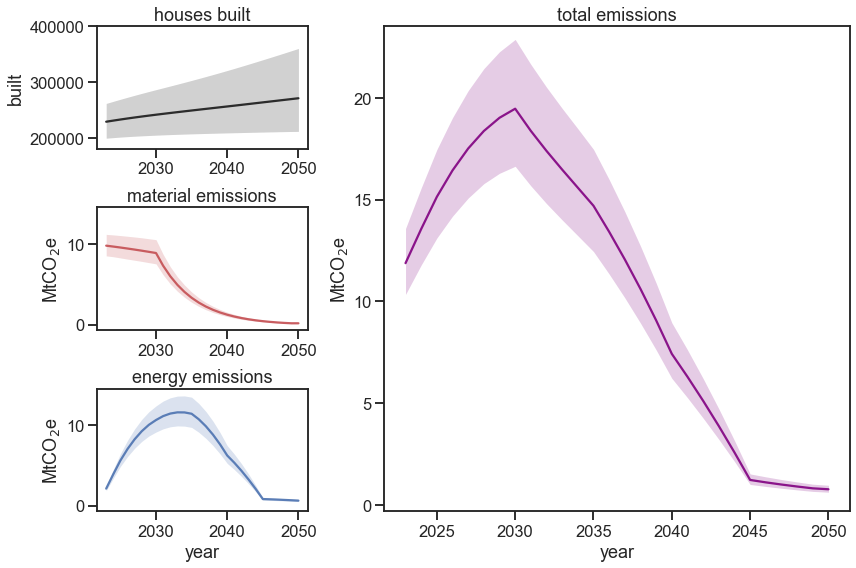

In [9]:
# Setup the figure and gridspec
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[1,2.2])

# Add subplots
ax1 = fig.add_subplot(gs[0, 0]) # First row, first column
ax2 = fig.add_subplot(gs[1, 0]) # Second row, first column
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[:, 1]) # Both rows, second column
axs = [ax1,ax2,ax3,ax4]

#built_df = pd.DataFrame(np.array(built_chain_mg).T)
#emb_chain_df = pd.DataFrame(np.array(embodied_chains_hg).T)
#op_chain_df = pd.DataFrame(np.array(operational_chains_hg).T)

built_df_l = [pd.DataFrame(np.array(built_chain_lg).T),pd.DataFrame(np.array(built_chain_mg).T),pd.DataFrame(np.array(built_chain_hg).T)]
emb_chain_df_l = [pd.DataFrame(np.array(embodied_chains_lg).T),pd.DataFrame(np.array(embodied_chains_mg).T),pd.DataFrame(np.array(embodied_chains_hg).T)]
op_chain_df_l = [pd.DataFrame(np.array(operational_chains_lg).T),pd.DataFrame(np.array(operational_chains_mg).T),pd.DataFrame(np.array(operational_chains_hg).T)]
tot_chain_df_l = [e+o for (e,o) in zip(emb_chain_df_l, op_chain_df_l)]

clrs = ['k','r','b','purple']

for en, i_df in enumerate([built_df_l, emb_chain_df_l, op_chain_df_l, tot_chain_df_l]):
    minr = i_df[0].min(axis=1)
    maxr = i_df[2].max(axis=1)
    meanr = np.array([i_df[0].mean(axis=1),i_df[1].mean(axis=1),i_df[2].mean(axis=1)]).mean(axis=0)

    axs[en].fill_between(years, minr, maxr, color=clrs[en], alpha=0.2, linewidth=0)


    axs[en].plot(years, meanr, color=clrs[en], alpha=0.9)

y_lims = [[180000,400000],[-0.7,14.5], [-0.7,14.5], [-0.3,23.5]]
titles = ['houses built','material emissions','energy emissions','total emissions']
labs = ['built','MtCO$_2$e','MtCO$_2$e','MtCO$_2$e']
for en, a in enumerate(axs):
    a.set_ylim(y_lims[en])
    #a.hlines(0, 2020, 2055)
    a.set_xlabel('')
    if en >=2:
        a.set_xlabel('year')
    a.set_ylabel(labs[en])
    a.set_title(titles[en])

#plt.suptitle('2023-2050 emissions - likely emission factors')
plt.tight_layout()
#plt.savefig('2023_2050_chain_results.png', bbox_inches='tight')

In [ ]:
for en, i_df in enumerate([built_df, emb_chain_df, op_chain_df, tot_chain_df]):
    minr = i_df.min(axis=1)
    maxr = i_df.max(axis=1)
    meanr = i_df.mean(axis=1)

    axs[en].fill_between(years, minr, maxr, color=clrs[en], alpha=0.2, linewidth=0)
    axs[en].plot(years, meanr, color=clrs[en], alpha=0.9)

y_lims = [[-0.4,13.5], [-0.4,13.5], [-0.3,22]]
titles = ['houses built','material emissions','energy emissions','total emissions']
labs = ['built','MtCO$_2$e','MtCO$_2$e','MtCO$_2$e']
for en, a in enumerate(axs):
    #a.set_ylim(y_lims[en])
    #a.hlines(0, 2020, 2055)
    a.set_xlabel('')
    if en >=2:
        a.set_xlabel('year')
    a.set_ylabel(labs[en])
    a.set_title(titles[en])

plt.tight_layout()

In [99]:
np.array(embodied_chains_lg).shape

(300, 28)

## Analysis
Summary statistics, looking at the different growth scenarios

In [89]:
emission_sum_lg = np.sum(embodied_chains_lg, axis=1) + np.sum(operational_chains_lg, axis=1)
emission_sum_mg = np.sum(embodied_chains_mg, axis=1) + np.sum(operational_chains_mg, axis=1)
emission_sum_hg = np.sum(embodied_chains_hg, axis=1) + np.sum(operational_chains_hg, axis=1)

In [90]:
print('95% CI for mean cumulative emissions - LOW GROWTH:', np.mean(emission_sum_lg), "+/-",
       1.96*np.std(emission_sum_lg, ddof = 1)/np.sqrt(replications))
print('95% CI for mean cumulative emissions - MEDIUM GROWTH:', np.mean(emission_sum_mg), "+/-",
       1.96*np.std(emission_sum_mg, ddof = 1)/np.sqrt(replications))
print('95% CI for mean cumulative emissions - HIGH GROWTH:', np.mean(emission_sum_hg), "+/-",
       1.96*np.std(emission_sum_hg, ddof = 1)/np.sqrt(replications))

95% CI for mean cumulative emissions - LOW GROWTH: 283.96708796702455 +/- 1.3623104374442596
95% CI for mean cumulative emissions - MEDIUM GROWTH: 290.6848894591736 +/- 1.4760447985194303
95% CI for mean cumulative emissions - HIGH GROWTH: 296.1041531041049 +/- 1.5694345342533005


Save and export results to csv - total emissions sum

In [81]:
np.savetxt("lg_403030_"+Impr.factor_range+"_300r.csv", emission_sum_lg, delimiter=",")
np.savetxt("mg_403030_"+Impr.factor_range+"_300r.csv", emission_sum_mg, delimiter=",")
np.savetxt("hg_403030_"+Impr.factor_range+"_300r.csv", emission_sum_hg, delimiter=",")

Save and export results to csv - embodied vs operational emissions sum

In [91]:
np.savetxt("lg_emb_403030_"+Impr.factor_range+"_300r.csv", np.sum(embodied_chains_lg, axis=1), delimiter=",")
np.savetxt("mg_emb_403030_"+Impr.factor_range+"_300r.csv", np.sum(embodied_chains_mg, axis=1), delimiter=",")
np.savetxt("hg_emb_403030_"+Impr.factor_range+"_300r.csv", np.sum(embodied_chains_hg, axis=1), delimiter=",")

np.savetxt("lg_op_403030_"+Impr.factor_range+"_300r.csv", np.sum(operational_chains_lg, axis=1), delimiter=",")
np.savetxt("mg_op_403030_"+Impr.factor_range+"_300r.csv", np.sum(operational_chains_mg, axis=1), delimiter=",")
np.savetxt("hg_op_403030_"+Impr.factor_range+"_300r.csv", np.sum(operational_chains_hg, axis=1), delimiter=",")

Save a dataframe for recreating the figure above

In [37]:
built_df_l[0]

column_labs = ['built_lowest','built_highest','built_mean',
               'embodied_lowest','embodied_highest','embodied_mean',
               'operational_lowest','operational_highest','operational_mean',
               'sum_lowest','sum_highest','sum_mean']

column_vals = []
for en, i_df in enumerate([built_df_l, emb_chain_df_l, op_chain_df_l, tot_chain_df_l]):
    minr = i_df[0].min(axis=1).values
    maxr = i_df[2].max(axis=1).values
    meanr = np.array([i_df[0].mean(axis=1),i_df[1].mean(axis=1),i_df[2].mean(axis=1)]).mean(axis=0)
    column_vals.append(minr)
    column_vals.append(maxr)
    column_vals.append(meanr)

In [38]:
pd.DataFrame(data=np.array(column_vals).T, columns=column_labs, index=years).to_csv('chain_figure_likely_opti.csv')